In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the necessary modules
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

from datetime import datetime
from time import time

%matplotlib inline
sns.set()
sns.set_context('talk')

pd.options.display.max_columns = 20
pd.set_option('float_format', '{:f}'.format)

## Importing and pivoting data

#### Consumos

In [2]:
inicio = time()
consumos = pd.read_csv('C:/Users/Alvaro Santoma/Documents/ASOS aws/Sprint 6/tres_asos_aux_ult_consumos.csv', error_bad_lines=False, warn_bad_lines = False)
consumos=consumos.sort_values(by=['ID_SS_E', 'MONTH_Y'])
consumos["MONTH_Y"]= pd.to_datetime(consumos["MONTH_Y"], format='%Y/%m')
consumos = consumos.rename(columns={'ID_SS_E': 'ID_SECTOR_SUPPLY'})
print(time() - inicio)

26.66007113456726


In [3]:
consumos.head()

,ID_SECTOR_SUPPLY,MONTH_Y,CONSUM_TOTAL,TIPO_CLIENTE
0,700000000004,2015-01-01,526.000000,4
1,700000000004,2015-02-01,268.000000,4
2,700000000004,2015-03-01,209.000000,4
3,700000000004,2015-04-01,214.000000,4
4,700000000004,2015-05-01,201.000000,4


In [4]:
consumos.shape  #17,24M

(17247772, 4)

#### Bills

In [5]:
inicio = time()
bills = pd.read_csv('C:/Users/Alvaro Santoma/Documents/ASOS aws/Sprint 6/tres_gccon_bills.csv', error_bad_lines=False, warn_bad_lines = False, index_col=False)
bills = bills.rename(columns={"TO_CHAR(PRINT_DATE,'MM/YYYY')": 'DATE'})
bills=bills.sort_values(by=['ID_CONTRACT', 'DATE'])
bills["BILLS"] = (bills["TOTAL_BILLS"]).astype(float) + (bills.iloc[:,3]/100)
bills["DATE"] = pd.to_datetime(bills["DATE"], format='%m/%Y')
print(time() - inicio)

100.39531016349792


In [6]:
bills.shape  # 20,5M

(20493272, 5)

#### Contracts

In [7]:
inicio = time()
contracts = pd.read_csv('C:/Users/Alvaro Santoma/Documents/ASOS aws/Sprint 6/gccon_contracted_services.csv', error_bad_lines=False, warn_bad_lines = False)
contracts["FROM_DATE"] = pd.to_datetime(contracts["FROM_DATE"], format='%d/%m/%y')
contracts["END_DATE"] = pd.to_datetime(contracts["END_DATE"], format='%d/%m/%y')
consumos = consumos.rename(columns={'MONTH_Y': 'DATE'})
print(time() - inicio)

7.1740562915802


In [8]:
contracts.head()

,ID_CONTRACT,ID_SECTOR_SUPPLY,FROM_DATE,END_DATE
0,1100000001291,700003137036,2013-04-30,NaT
1,1100000001292,700000363186,2009-06-30,2014-09-29
2,1100000001293,700003547303,2017-08-31,NaT
3,1100000001294,700000298261,2015-03-17,NaT
4,1100000001295,700000389368,2013-10-07,NaT


In [9]:
contracts.shape

(1164755, 4)

#### Bills + Contracts

In [10]:
inicio = time()
bills_contracts = pd.merge(bills, contracts, on='ID_CONTRACT', how='left')
bills_contracts= bills_contracts[[ 'ID_CONTRACT','ID_SECTOR_SUPPLY','DATE', 'TOTAL_BILLS',
                            ' "TOTAL_BILLS_DEC"', 'BILLS',  'FROM_DATE',
                            'END_DATE']]
print(time() - inicio)

7.907966613769531


In [11]:
bills_contracts.head()

,ID_CONTRACT,ID_SECTOR_SUPPLY,DATE,TOTAL_BILLS,"""TOTAL_BILLS_DEC""",BILLS,FROM_DATE,END_DATE
0,5014,700000846268.000000,2018-01-01,30,9.000000,30.090000,2017-11-06,NaT
1,5014,700000846268.000000,2017-11-01,11,62.000000,11.620000,2017-11-06,NaT
2,5015,700003043092.000000,2018-01-01,602,69.000000,602.690000,2017-11-06,NaT
3,5016,700000846270.000000,2018-01-01,51,12.000000,51.120000,2017-11-06,NaT
4,5016,700000846270.000000,2017-11-01,16,89.000000,16.890000,2017-11-06,NaT


#### Bills + Contracts + Consum

In [53]:
#divido línea a línea para entender qué pasa
bills_contracts_consumos = pd.merge(bills_contracts, consumos, 
                                    on=['ID_SECTOR_SUPPLY', "DATE"], how='outer', suffixes=('_BILL', '_CONS'))
bills_contracts_consumos.shape

(20867488, 10)

In [54]:
bills_contracts_consumos["TIPO_CLIENTE"] = bills_contracts_consumos["TIPO_CLIENTE"].fillna(0)
bills_contracts_consumos.shape

(20867488, 10)

In [55]:
bills_contracts_consumos = bills_contracts_consumos.sort_values(['ID_SECTOR_SUPPLY','DATE'])
bills_contracts_consumos.shape

(20867488, 10)

In [56]:
counts = dict(bills_contracts_consumos.groupby('ID_SECTOR_SUPPLY')['DATE'].count())


In [57]:
bills_contracts_consumos = bills_contracts_consumos[bills_contracts_consumos["ID_SECTOR_SUPPLY"].isnull()==False]
bills_contracts_consumos.shape

(20867486, 10)

In [58]:
index_l = [list(range(value)) for key, value in counts.items()]

index_pivot = [item for sublist in index_l for item in sublist]
bills_contracts_consumos["PERIODO"] = index_pivot
bills_contracts_consumos.shape

(20867486, 11)

In [59]:
bills_contracts_consumos["TIPO_CLIENTE"].value_counts()

4.000000    14459976
0.000000     3469258
1.000000     2482492
6.000000      419644
3.000000       34129
7.000000        1331
9.000000         656
Name: TIPO_CLIENTE, dtype: int64

In [60]:
bills_contracts_consumos["RATIO_COST"] = bills_contracts_consumos["BILLS"]/bills_contracts_consumos["CONSUM_TOTAL"]
bills_contracts_consumos.shape

(20867486, 12)

In [61]:
bills_contracts_consumos["PERIODO_LARGO"] = ([1 if (x==24) else 0 for x in bills_contracts_consumos["PERIODO"]])
bills_contracts_consumos.shape

(20867486, 13)

In [62]:
bills_contracts_consumos["PERIODO_LARGO"].value_counts()

0    20320345
1      547141
Name: PERIODO_LARGO, dtype: int64

In [63]:
filtro_idss = bills_contracts_consumos.loc[bills_contracts_consumos["PERIODO_LARGO"] ==1].iloc[:,1]

In [64]:
bills_contracts_consumos = bills_contracts_consumos[bills_contracts_consumos['ID_SECTOR_SUPPLY'].isin(filtro_idss)]
bills_contracts_consumos.shape

(18764133, 13)

In [68]:
bills_contracts_consumos["TIPO_CLIENTE"].value_counts()

4.000000    12954893
0.000000     2989086
1.000000     2408760
6.000000      376991
3.000000       32535
7.000000        1258
9.000000         610
Name: TIPO_CLIENTE, dtype: int64

In [66]:
bills_contracts_consumos["PERIODO"].value_counts()

0     547141
12    547141
22    547141
21    547141
20    547141
19    547141
18    547141
17    547141
16    547141
15    547141
14    547141
13    547141
11    547141
24    547141
10    547141
9     547141
8     547141
7     547141
6     547141
5     547141
4     547141
3     547141
2     547141
1     547141
23    547141
25    519836
26    497363
27    469927
28    445020
29    418990
30    397221
31    377194
32    354569
33    336654
34    315984
35    291709
36    265418
37    238659
38    107033
39     32316
40     11295
41      4082
42      1488
43       536
44       196
45        68
46        30
47        13
48         5
49         1
50         1
Name: PERIODO, dtype: int64

In [65]:
bills_contracts_consumos_filtered1 = bills_contracts_consumos[bills_contracts_consumos["PERIODO"]<24]
bills_contracts_consumos_filtered1.shape

(13131384, 13)

In [67]:
bills_contracts_consumos_filtered1["TIPO_CLIENTE"].value_counts()

4.000000    9254607
0.000000    1868661
1.000000    1613726
6.000000     361108
3.000000      31839
7.000000        836
9.000000        607
Name: TIPO_CLIENTE, dtype: int64

In [38]:
bills_contracts_consumos_filtered2 = bills_contracts_consumos_filtered1[(bills_contracts_consumos["TIPO_CLIENTE"]==1 )|(bills_contracts_consumos["TIPO_CLIENTE"]==3)  | (bills_contracts_consumos["TIPO_CLIENTE"]==4) | (bills_contracts_consumos["TIPO_CLIENTE"]==6) | (bills_contracts_consumos["TIPO_CLIENTE"]==7) | (bills_contracts_consumos["TIPO_CLIENTE"]==9)]
bills_contracts_consumos_filtered2.shape

C:\Users\Alvaro Santoma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(11262723, 13)

In [39]:
bills_contracts_consumos_filtered2["TIPO_CLIENTE"].value_counts()

4.000000    9254607
1.000000    1613726
6.000000     361108
3.000000      31839
7.000000        836
9.000000        607
Name: TIPO_CLIENTE, dtype: int64

In [69]:
#todo hasta la carga
inicio = time()
bills_contracts_consumos = pd.merge(bills_contracts, consumos, 
                                    on=['ID_SECTOR_SUPPLY', "DATE"], how='outer', suffixes=('_BILL', '_CONS'))
bills_contracts_consumos["TIPO_CLIENTE"] = bills_contracts_consumos["TIPO_CLIENTE"].fillna(0)
bills_contracts_consumos = bills_contracts_consumos.sort_values(['ID_SECTOR_SUPPLY','DATE'], ascending=False)
counts = dict(bills_contracts_consumos.groupby('ID_SECTOR_SUPPLY')['DATE'].count())
bills_contracts_consumos = bills_contracts_consumos[bills_contracts_consumos["ID_SECTOR_SUPPLY"].isnull()==False]

index_l = [list(range(value)) for key, value in counts.items()]

index_pivot = [item for sublist in index_l for item in sublist]
bills_contracts_consumos["PERIODO"] = index_pivot

bills_contracts_consumos["RATIO_COST"] = bills_contracts_consumos["BILLS"]/bills_contracts_consumos["CONSUM_TOTAL"]
bills_contracts_consumos["PERIODO_LARGO"] = ([1 if (x==24) else 0 for x in bills_contracts_consumos["PERIODO"]])

filtro_idss = bills_contracts_consumos.loc[bills_contracts_consumos["PERIODO_LARGO"] ==1].iloc[:,1]

bills_contracts_consumos = bills_contracts_consumos[bills_contracts_consumos['ID_SECTOR_SUPPLY'].isin(filtro_idss)]


bills_contracts_consumos_filtered = bills_contracts_consumos[bills_contracts_consumos["PERIODO"]<24]

bills_contracts_consumos_filtered = bills_contracts_consumos_filtered[(bills_contracts_consumos["TIPO_CLIENTE"]==1 )|(bills_contracts_consumos["TIPO_CLIENTE"]==3)  | (bills_contracts_consumos["TIPO_CLIENTE"]==4) | (bills_contracts_consumos["TIPO_CLIENTE"]==6) | (bills_contracts_consumos["TIPO_CLIENTE"]==7) | (bills_contracts_consumos["TIPO_CLIENTE"]==9)]


print(time() - inicio)

C:\Users\Alvaro Santoma\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


108.1521565914154


In [70]:
bills_contracts_consumos_filtered.shape

(10119191, 13)

In [25]:
bills_contracts_consumos = bills_contracts_consumos.sort_values(["ID_CONTRACT", "DATE"])
bills_contracts_consumos.head(100)


,ID_CONTRACT,ID_SECTOR_SUPPLY,DATE,TOTAL_BILLS,"""TOTAL_BILLS_DEC""",BILLS,FROM_DATE,END_DATE,CONSUM_TOTAL,TIPO_CLIENTE,PERIODO,RATIO_COST
1,5014.000000,700000846268.000000,2017-11-01,11.000000,62.000000,11.620000,2017-11-06,NaT,117.000000,4.000000,17,0.099316
0,5014.000000,700000846268.000000,2018-01-01,30.000000,9.000000,30.090000,2017-11-06,NaT,105.000000,4.000000,19,0.286571
3,5015.000000,700003043092.000000,2018-01-01,602.000000,69.000000,602.690000,2017-11-06,NaT,nan,0.000000,20,nan
5,5016.000000,700000846270.000000,2017-11-01,16.000000,89.000000,16.890000,2017-11-06,NaT,293.000000,4.000000,17,0.057645
4,5016.000000,700000846270.000000,2018-01-01,51.000000,12.000000,51.120000,2017-11-06,NaT,461.000000,4.000000,19,0.110889
8,5017.000000,700002388163.000000,2017-11-01,20.000000,81.000000,20.810000,2017-11-04,NaT,nan,0.000000,17,nan
7,5017.000000,700002388163.000000,2018-01-01,63.000000,83.000000,63.830000,2017-11-04,NaT,nan,0.000000,19,nan
10,5018.000000,700003049013.000000,2018-01-01,22.000000,2.000000,22.020000,2017-11-06,NaT,nan,0.000000,18,nan
13,5019.000000,700002854563.000000,2017-12-01,35.000000,33.000000,35.330000,2017-11-06,NaT,nan,0.000000,28,nan
11,5019.000000,700002854563.000000,2018-01-01,36.000000,97.000000,36.970000,2017-11-06,NaT,nan,0.000000,29,nan


In [29]:
bills_contracts_consumos.loc[bills_contracts_consumos['ID_SECTOR_SUPPLY']==700000846268]

,ID_CONTRACT,ID_SECTOR_SUPPLY,DATE,TOTAL_BILLS,"""TOTAL_BILLS_DEC""",BILLS,FROM_DATE,END_DATE,CONSUM_TOTAL,TIPO_CLIENTE,PERIODO,RATIO_COST
1,5014.000000,700000846268.000000,2017-11-01,11.000000,62.000000,11.620000,2017-11-06,NaT,117.000000,4.000000,17,0.099316
0,5014.000000,700000846268.000000,2018-01-01,30.000000,9.000000,30.090000,2017-11-06,NaT,105.000000,4.000000,19,0.286571
65639,1100000003831.000000,700000846268.000000,2015-01-01,54.000000,93.000000,54.930000,2013-07-15,2017-11-05,533.000000,4.000000,0,0.103058
65642,1100000003831.000000,700000846268.000000,2015-03-01,34.000000,52.000000,34.520000,2013-07-15,2017-11-05,150.000000,4.000000,1,0.230133
65645,1100000003831.000000,700000846268.000000,2015-05-01,48.000000,68.000000,48.680000,2013-07-15,2017-11-05,5.000000,4.000000,2,9.736000
65648,1100000003831.000000,700000846268.000000,2015-07-01,26.000000,53.000000,26.530000,2013-07-15,2017-11-05,0.000000,4.000000,3,inf
65651,1100000003831.000000,700000846268.000000,2015-09-01,26.000000,69.000000,26.690000,2013-07-15,2017-11-05,3.000000,4.000000,4,8.896667
65654,1100000003831.000000,700000846268.000000,2015-11-01,32.000000,87.000000,32.870000,2013-07-15,2017-11-05,119.000000,4.000000,5,0.276218
65640,1100000003831.000000,700000846268.000000,2016-01-01,32.000000,87.000000,32.870000,2013-07-15,2017-11-05,119.000000,4.000000,6,0.276218
65643,1100000003831.000000,700000846268.000000,2016-03-01,32.000000,87.000000,32.870000,2013-07-15,2017-11-05,119.000000,4.000000,7,0.276218


In [11]:
bills_contracts_consumos = bills_contracts_consumos.sort_values(['ID_SECTOR_SUPPLY','DATE'])

In [9]:
counts = dict(bills_contracts_consumos.groupby('ID_SECTOR_SUPPLY')['DATE'].count())

In [10]:
bills_contracts_consumos = bills_contracts_consumos[bills_contracts_consumos["ID_SECTOR_SUPPLY"].isnull()==False]

In [12]:
index_l = [list(range(value)) for key, value in counts.items()]

index_pivot = [item for sublist in index_l for item in sublist]

In [46]:
index_pivot

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,


In [13]:
bills_contracts_consumos["PERIODO"] = index_pivot

In [30]:
bills_contracts_consumos.shape

(20867486, 11)

In [14]:
bills_contracts_consumos["PERIODO_LARGO"] = ([1 if (x==24) else 0 for x in bills_contracts_consumos["PERIODO"]])

In [15]:
# Aquellos que tengan 24 periodos de consumo o más
filtro_idss = bills_contracts_consumos.loc[bills_contracts_consumos["PERIODO_LARGO"] ==1].iloc[:,1]

In [94]:
type(filtro_idss)

pandas.core.series.Series

In [16]:
bills_contracts_consumos = bills_contracts_consumos[bills_contracts_consumos['ID_SECTOR_SUPPLY'].isin(filtro_idss)]

In [17]:
bills_contracts_consumos["RATIO_COST"] = bills_contracts_consumos["BILLS"]/bills_contracts_consumos["CONSUM_TOTAL"]

In [97]:
bills_contracts_consumos.head(40)

,ID_CONTRACT,ID_SECTOR_SUPPLY,DATE,TOTAL_BILLS,"""TOTAL_BILLS_DEC""",BILLS,FROM_DATE,END_DATE,CONSUM_TOTAL,TIPO_CLIENTE,PERIODO,RATIO_COST,PERIODO_LARGO
1814415,1.200000e+12,7.000000e+11,2015-01-01,41.0,49.0,41.49,2009-06-30,NaT,526.0,4.0,0,0.078878,0
1814419,1.200000e+12,7.000000e+11,2015-02-01,21.0,2.0,21.02,2009-06-30,NaT,268.0,4.0,1,0.078433,0
1814423,1.200000e+12,7.000000e+11,2015-03-01,17.0,87.0,17.87,2009-06-30,NaT,209.0,4.0,2,0.085502,0
1814426,1.200000e+12,7.000000e+11,2015-04-01,18.0,14.0,18.14,2009-06-30,NaT,214.0,4.0,3,0.084766,0
1814429,1.200000e+12,7.000000e+11,2015-05-01,17.0,45.0,17.45,2009-06-30,NaT,201.0,4.0,4,0.086816,0
1814432,1.200000e+12,7.000000e+11,2015-06-01,20.0,27.0,20.27,2009-06-30,NaT,254.0,4.0,5,0.079803,0
1814435,1.200000e+12,7.000000e+11,2015-07-01,16.0,7.0,16.07,2009-06-30,NaT,187.0,4.0,6,0.085936,0
1814438,1.200000e+12,7.000000e+11,2015-08-01,20.0,6.0,20.06,2009-06-30,NaT,250.0,4.0,7,0.080240,0
1814441,1.200000e+12,7.000000e+11,2015-09-01,19.0,31.0,19.31,2009-06-30,NaT,236.0,4.0,8,0.081822,0
1814444,1.200000e+12,7.000000e+11,2015-10-01,19.0,36.0,19.36,2009-06-30,NaT,237.0,4.0,9,0.081688,0


In [18]:
bills_contracts_consumos_filtered = bills_contracts_consumos[bills_contracts_consumos["PERIODO"]<24]
bills_contracts_consumos_filtered.shape

(13131384, 13)

In [19]:
bills_contracts_consumos_filtered = bills_contracts_consumos_filtered[(bills_contracts_consumos["TIPO_CLIENTE"]==1 )|(bills_contracts_consumos["TIPO_CLIENTE"]==3)  | (bills_contracts_consumos["TIPO_CLIENTE"]==4) | (bills_contracts_consumos["TIPO_CLIENTE"]==6) | (bills_contracts_consumos["TIPO_CLIENTE"]==7) | (bills_contracts_consumos["TIPO_CLIENTE"]==9)]

C:\Users\Alvaro Santoma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [20]:
bills_contracts_consumos_filtered.columns

Index(['ID_CONTRACT', 'ID_SECTOR_SUPPLY', 'DATE', 'TOTAL_BILLS',
       ' "TOTAL_BILLS_DEC"', 'BILLS', 'FROM_DATE', 'END_DATE', 'CONSUM_TOTAL',
       'TIPO_CLIENTE', 'PERIODO', 'RATIO_COST', 'PERIODO_LARGO'],
      dtype='object')

In [44]:
bills_contracts_consumos_filtered = bills_contracts_consumos_filtered.drop(['END_DATE','TOTAL_BILLS',' "TOTAL_BILLS_DEC"','FROM_DATE','ID_CONTRACT', "DATE", "PERIODO_LARGO", "RATIO_COST"], axis=1 )

In [71]:
bills_contracts_consumos_filtered.columns

Index(['ID_CONTRACT', 'ID_SECTOR_SUPPLY', 'DATE', 'TOTAL_BILLS',
       ' "TOTAL_BILLS_DEC"', 'BILLS', 'FROM_DATE', 'END_DATE', 'CONSUM_TOTAL',
       'TIPO_CLIENTE', 'PERIODO', 'RATIO_COST', 'PERIODO_LARGO'],
      dtype='object')

In [52]:
inicio = time()
#bills_contracts_consumos_filtered = bills_contracts_consumos_filtered.drop(['END_DATE','TOTAL_BILLS',' "TOTAL_BILLS_DEC"','FROM_DATE','ID_CONTRACT', "DATE"], axis=1 )
bcc_pivot = bills_contracts_consumos_filtered.pivot_table(index = ['ID_SECTOR_SUPPLY', "TIPO_CLIENTE"],
                                      values = ['BILLS', "CONSUM_TOTAL"], columns = 'PERIODO')
bcc_pivot = bcc_pivot.fillna(0)
bcc_pivot = bcc_pivot.reset_index(level=[0,1])
bcc_pivot.columns = bcc_pivot.columns.droplevel(1)

col_names = list(bcc_pivot.columns) 
col_names[0] = "ID_SECTOR_SUPPLY"
col_names[1] =  "TIPO_CLIENTE"
col_names[2:26] = ["BILL"+str(i+1) for i in range(24)]
col_names[26:50] = ["CONSUM"+str(i+1) for i in range(24)]
#col_names[50:74] = ["RATIO_COST"+str(i+1) for i in range(24)]
bcc_pivot.columns = col_names

bcc_pivot["Churn"] = [1 if ((x==3) |(x==6) |(x==9)) else 0 for x in bcc_pivot["TIPO_CLIENTE"]]
bcc_pivot["SUMA_CONSUMOS"] = bcc_pivot.iloc[:,26:50].sum(axis=1)
bcc_pivot["SUMA_BILLS"] = bcc_pivot.iloc[:,2:26].sum(axis=1)

print (time() - inicio)

13.870059967041016


In [53]:
bcc_pivot["Churn"] = [1 if ((x==3) |(x==6) |(x==9)) else 0 for x in bcc_pivot["TIPO_CLIENTE"]]

In [55]:
bcc_pivot["SUMA_CONSUMOS"].describe()

count    5.012190e+05
mean     1.399773e+04
std      1.953890e+06
min     -2.900700e+04
25%      1.567000e+03
50%      4.467000e+03
75%      8.494000e+03
max      1.200003e+09
Name: SUMA_CONSUMOS, dtype: float64

In [57]:
bcc_pivot = bcc_pivot[bcc_pivot["SUMA_CONSUMOS"]<1000000]

In [59]:
# se filtran 78 valores
bcc_pivot.shape

(501137, 53)

In [60]:
bcc_pivot.to_csv("bills_consum_filtro.csv", sep=";")

In [109]:
### Estudio y exploratorio

In [3]:
bcc_pivot = pd.read_csv('C:/Users/Alvaro Santoma/Documents/ASOS aws/Sprint 6/Notebooks/bills_consum_filtro.csv', sep = ';',error_bad_lines=False, warn_bad_lines = False)

In [4]:
bcc_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501137 entries, 0 to 501136
Data columns (total 54 columns):
Unnamed: 0          501137 non-null int64
ID_SECTOR_SUPPLY    501137 non-null float64
TIPO_CLIENTE        501137 non-null float64
BILL1               501137 non-null float64
BILL2               501137 non-null float64
BILL3               501137 non-null float64
BILL4               501137 non-null float64
BILL5               501137 non-null float64
BILL6               501137 non-null float64
BILL7               501137 non-null float64
BILL8               501137 non-null float64
BILL9               501137 non-null float64
BILL10              501137 non-null float64
BILL11              501137 non-null float64
BILL12              501137 non-null float64
BILL13              501137 non-null float64
BILL14              501137 non-null float64
BILL15              501137 non-null float64
BILL16              501137 non-null float64
BILL17              501137 non-null float64
BILL18     

In [9]:
bcc_pivot.head()

,Unnamed: 0,ID_SECTOR_SUPPLY,TIPO_CLIENTE,BILL1,BILL2,BILL3,BILL4,BILL5,BILL6,BILL7,...,RATIO_COST16,RATIO_COST17,RATIO_COST18,RATIO_COST19,RATIO_COST20,RATIO_COST21,RATIO_COST22,RATIO_COST23,RATIO_COST24,Churn
0,0,7.000000e+11,4.0,41.49,21.02,17.87,18.14,17.45,20.27,16.07,...,0.081597,0.083097,0.000000,0.076603,0.082707,0.084766,0.085502,0.080240,0.082851,0
1,1,7.000000e+11,4.0,0.00,121.92,0.00,122.72,121.97,122.87,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2,7.000000e+11,4.0,0.00,0.00,0.00,27.76,35.38,31.81,33.03,...,0.000000,0.140571,0.145642,0.121463,0.113654,0.097713,0.106686,0.121288,0.126118,0
3,3,7.000000e+11,4.0,28.16,26.56,26.34,31.15,27.67,31.62,32.85,...,0.182157,0.189534,0.188154,0.166137,0.129249,0.147179,0.161481,0.324330,6.627500,0
4,4,7.000000e+11,4.0,24.97,19.64,18.01,18.68,17.99,19.86,44.62,...,0.121007,0.110671,0.115629,0.081124,0.073171,0.076453,0.096256,0.090960,0.099655,0


In [5]:
bcc_pivot['TIPO_CLIENTE'].value_counts()

4.0    399862
1.0     67563
6.0     30867
3.0      2764
9.0        46
7.0        35
Name: TIPO_CLIENTE, dtype: int64

In [6]:
bcc_pivot['BILL1'].value_counts()

0.00      25627
26.69      9974
18.26      6245
13.64      4443
12.89      3392
27.84      2195
14.22      1692
9.41       1505
26.74      1416
111.72     1232
19.02      1125
6.74       1118
35.14      1071
25.38       980
28.49       891
36.68       880
145.31      818
18.62       810
27.01       696
18.31       695
13.69       672
45.05       668
26.08       665
13.65       631
17.86       617
16.95       613
9.08        593
26.85       592
23.04       580
11.58       540
          ...  
318.39        1
394.36        1
167.25        1
393.64        1
394.02        1
160.44        1
286.07        1
210.46        1
247.94        1
251.59        1
635.47        1
306.46        1
212.61        1
271.15        1
199.78        1
176.12        1
110.77        1
187.31        1
572.89        1
320.46        1
141.15        1
663.64        1
862.06        1
334.75        1
189.17        1
155.48        1
155.52        1
612.44        1
200.73        1
392.95        1
Name: BILL1, Length: 264

In [63]:
bcc_pivot['BILL2'].value_counts()

 0.00       40664
 26.69       8449
 18.26       5488
 13.64       4857
 12.89       2948
 27.84       1910
 14.22       1864
 9.41        1668
 26.74       1319
 6.74        1167
 19.02       1039
 18.62        914
 35.14        912
 25.38        881
 28.49        792
 36.68        714
 9.08         696
 17.86        693
 13.69        676
 18.31        655
 27.01        620
 23.04        607
 45.05        591
 13.65        577
 26.08        575
 22.08        559
 26.96        493
 11.58        493
 19.07        483
 16.95        480
            ...  
 335.25         1
 325.28         1
 454.36         1
 340.53         1
 564.65         1
 328.32         1
 349.06         1
 361.09         1
 1291.04        1
 503.07         1
 502.93         1
 322.51         1
 169.61         1
 149.76         1
 296.26         1
 170.52         1
 251.91         1
 139.56         1
 282.95         1
 340.27         1
 198.53         1
 193.77         1
 162.63         1
 289.83         1
 568.45   

In [64]:
bcc_pivot['BILL2'].describe()

count    501137.000000
mean         46.949538
std          75.350606
min       -5823.590000
25%          20.070000
50%          32.660000
75%          53.970000
max       17250.450000
Name: BILL2, dtype: float64

In [65]:
bcc_pivot['CONSUM1'].describe()

count    501137.000000
mean        535.504884
std        1472.775223
min       -9774.000000
25%          29.000000
50%         225.000000
75%         536.000000
max      301797.000000
Name: CONSUM1, dtype: float64

In [66]:
bcc_pivot.describe()

,ID_SECTOR_SUPPLY,TIPO_CLIENTE,BILL1,BILL2,BILL3,BILL4,BILL5,BILL6,BILL7,BILL8,...,CONSUM18,CONSUM19,CONSUM20,CONSUM21,CONSUM22,CONSUM23,CONSUM24,Churn,SUMA_CONSUMOS,SUMA_BILLS
count,5.011370e+05,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,...,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000,501137.000000
mean,7.002282e+11,3.713883,52.682508,46.949538,41.838763,41.155608,39.286536,37.277512,39.696778,39.526356,...,268.825136,282.451342,294.377529,294.757759,281.172580,278.135017,295.216176,0.067201,8212.229642,846.560132
std,4.024431e+09,1.177425,85.822050,75.350606,69.269808,63.776091,69.748789,60.525463,69.485212,67.742555,...,1069.772518,1191.621047,1288.777711,1389.808553,1810.652627,1188.115487,1119.190660,0.250370,23115.394618,1193.154717
min,7.000000e+11,1.000000,-3696.220000,-5823.590000,-8876.620000,-2771.450000,-2781.540000,-3246.790000,-8484.520000,-4507.660000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-29007.000000,-49424.490000
25%,7.000010e+11,4.000000,23.070000,20.070000,18.650000,18.630000,18.220000,17.510000,18.050000,17.620000,...,13.000000,15.000000,13.000000,13.000000,13.000000,12.000000,10.000000,0.000000,1566.000000,443.640000
50%,7.000020e+11,4.000000,35.420000,32.660000,30.090000,29.950000,28.520000,27.430000,28.030000,27.990000,...,131.000000,133.000000,135.000000,132.000000,129.000000,132.000000,138.000000,0.000000,4466.000000,649.960000
75%,7.000031e+11,4.000000,59.350000,53.970000,48.080000,47.070000,45.010000,42.140000,44.170000,43.920000,...,265.000000,268.000000,279.000000,275.000000,264.000000,271.000000,288.000000,0.000000,8491.000000,928.690000
max,1.200003e+12,9.000000,17287.740000,17250.450000,11261.830000,5755.270000,13477.690000,7188.040000,8438.280000,6957.740000,...,206792.000000,118462.000000,142564.000000,263996.000000,864432.000000,176488.000000,166022.000000,1.000000,998765.000000,65886.400000


### Univariate Plotting

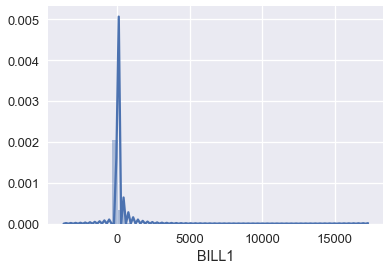

In [67]:
sns.distplot(bcc_pivot['BILL1'])

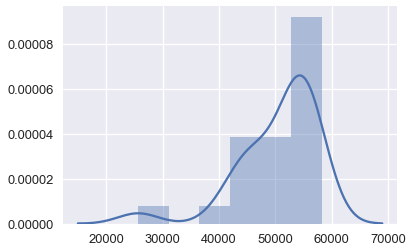

In [7]:
lista_ceros = []
for elem in range (0,24):
    lista_ceros.append(bcc_pivot['BILL'+str(1+elem)].value_counts()[0])
sns.distplot(lista_ceros)    

###Bivariate Plotting

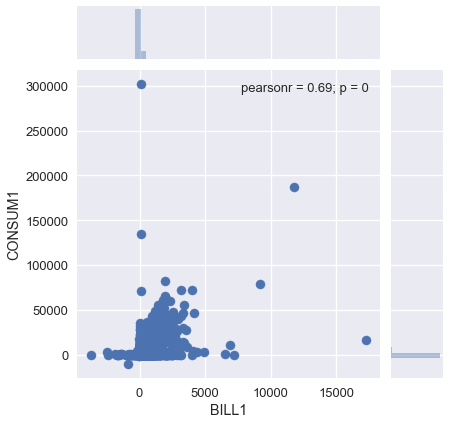

In [68]:
sns.jointplot(bcc_pivot['BILL1'], bcc_pivot['CONSUM1'])

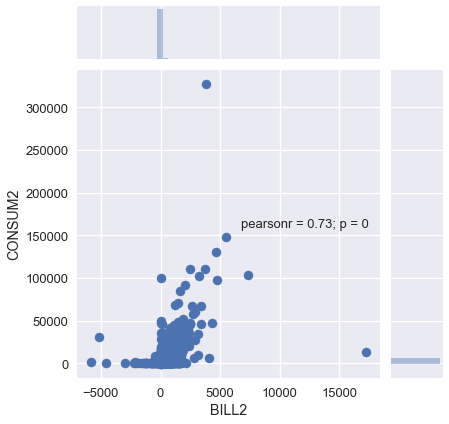

In [69]:
sns.jointplot(bcc_pivot['BILL2'], bcc_pivot['CONSUM2'])

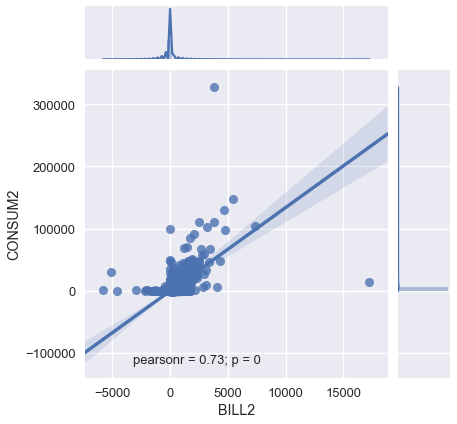

In [8]:
sns.jointplot(bcc_pivot['BILL2'], bcc_pivot['CONSUM2'], kind='reg')

In [ ]:
sns.jointplot(bcc_pivot['BILL14'], bcc_pivot['CONSUM14'])

In [71]:
bcc_pivot.corr()

,ID_SECTOR_SUPPLY,TIPO_CLIENTE,BILL1,BILL2,BILL3,BILL4,BILL5,BILL6,BILL7,BILL8,...,CONSUM18,CONSUM19,CONSUM20,CONSUM21,CONSUM22,CONSUM23,CONSUM24,Churn,SUMA_CONSUMOS,SUMA_BILLS
ID_SECTOR_SUPPLY,1.000000,0.013220,0.069517,-0.005493,-0.002912,-0.002697,-0.000269,0.000830,-0.000974,-0.002036,...,0.011405,0.006532,0.005011,0.002040,0.002344,0.003884,0.003014,-0.000827,0.002455,0.006491
TIPO_CLIENTE,0.013220,1.000000,0.043255,0.036361,0.027472,0.026595,0.015214,0.013455,0.009097,0.003451,...,0.005357,0.004330,0.001717,0.001407,0.001511,0.001554,0.001214,0.465952,0.016826,-0.004048
BILL1,0.069517,0.043255,1.000000,0.652171,0.551173,0.578691,0.496730,0.555914,0.520954,0.543879,...,0.455545,0.457264,0.440290,0.425589,0.305150,0.439663,0.469258,-0.025645,0.609650,0.723790
BILL2,-0.005493,0.036361,0.652171,1.000000,0.585092,0.610371,0.523887,0.584981,0.547214,0.568234,...,0.447306,0.453682,0.442635,0.418470,0.297372,0.418537,0.467822,-0.035508,0.617548,0.725597
BILL3,-0.002912,0.027472,0.551173,0.585092,1.000000,0.650903,0.555675,0.617892,0.569500,0.582438,...,0.488173,0.494040,0.474986,0.453703,0.318958,0.448285,0.493665,-0.039343,0.652294,0.744926
BILL4,-0.002697,0.026595,0.578691,0.610371,0.650903,1.000000,0.643617,0.671881,0.619204,0.632514,...,0.537280,0.531744,0.510919,0.487795,0.343549,0.486233,0.526208,-0.051901,0.691393,0.795772
BILL5,-0.000269,0.015214,0.496730,0.523887,0.555675,0.643617,1.000000,0.684628,0.586308,0.591177,...,0.502966,0.502541,0.484741,0.460596,0.311244,0.439568,0.465470,-0.051086,0.637720,0.737996
BILL6,0.000830,0.013455,0.555914,0.584981,0.617892,0.671881,0.684628,1.000000,0.698995,0.690438,...,0.573113,0.581226,0.567227,0.527091,0.362832,0.497536,0.521178,-0.062742,0.712407,0.810882
BILL7,-0.000974,0.009097,0.520954,0.547214,0.569500,0.619204,0.586308,0.698995,1.000000,0.707107,...,0.558008,0.588825,0.584480,0.536932,0.359721,0.482745,0.505388,-0.066097,0.699102,0.782571
BILL8,-0.002036,0.003451,0.543879,0.568234,0.582438,0.632514,0.591177,0.690438,0.707107,1.000000,...,0.587142,0.619450,0.625892,0.581399,0.396937,0.521245,0.532613,-0.072336,0.736958,0.809653


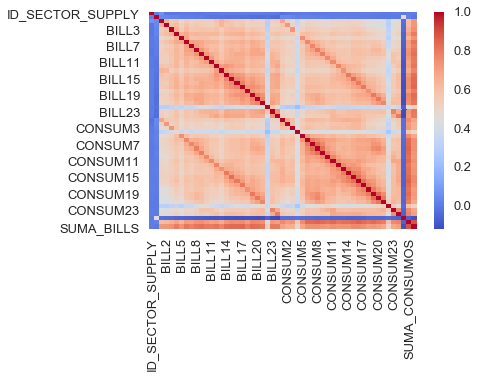

In [70]:
sns.heatmap(bcc_pivot.corr(), cmap='coolwarm')

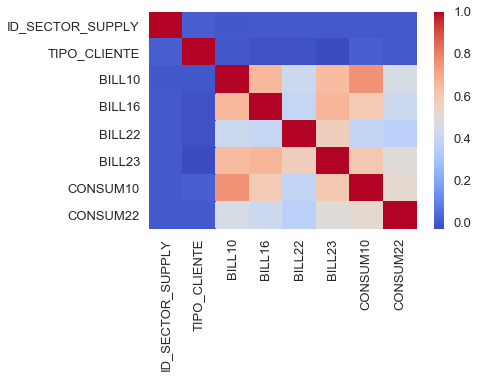

In [11]:
sns.heatmap(bcc_pivot.iloc[:,np.r_[1:3,12:13,18:19,24:26,36:37,48:49]].corr(), cmap='coolwarm')